In [87]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tomodata
import portfoliodata
import overlapping_group_lasso
import sparse_nuclear_norm
from overlapping_group_lasso import GroupL1
import sampledata
from numpy.linalg import norm
from tos import atos, aa_tos, Trace

Tomography : $\min_x \frac{1}{2}\|Ax-b\|_2^2 + \lambda |x|_1 - \mu \sum_{i=0}^n \log(x_i)$



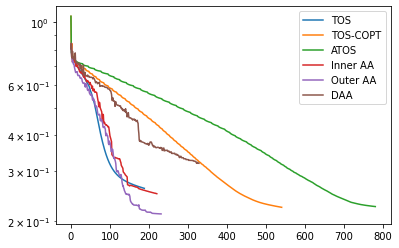

In [80]:
F,b,GT        = tomodata.generate_data()
Fb            = F.T @ b
[m,n]         = F.shape
Hinv1         = np.ones(n)
e             = np.ones(n)
t_f_copt        = tomodata.f3_copt(F,b,Fb)
t_f_grad        = t_f_copt.f_grad
tomo_stepsize = 2/0.00015339534146545738
lbd           = 1.e-8




tomo_tos_obj, tomo_tos_copt_obj, tomo_atos_obj, tomo_in_aa_tos_obj, tomo_out_aa_tos_obj, tomo_daa_tos_obj = [],[],[],[],[],[]

#Vanilla TOS
mu = np.array(1.e-6) #Barrier mu
t_h_opt = tomodata.f2_copt(mu) #Barrier Prox
t_g_opt = tomodata.f1_copt(e,lbd) #Soft-Threshold
x0_tomo = np.zeros(n)

tomo_tos_trace = Trace()
tomo_out = aa_tos(t_f_grad, x0_tomo, t_h_opt.prox, t_g_opt.prox, line_search=False, step_size = tomo_stepsize, barrier = mu, callback=tomo_tos_trace)
trace_obj = None
trace_obj = [norm(x-GT)/norm(GT) for x in tomo_tos_trace.trace_x]
tomo_tos_obj.append(trace_obj)


#Vanilla TOS - on ATOS framework
mu = np.array(1.e-6) #Barrier mu
t_h_opt = tomodata.f2_copt(mu) #Barrier Prox
t_g_opt = tomodata.f1_copt(e,lbd) #Soft-Threshold
x0_tomo = np.zeros(n)

tomo_tos_copt_trace = Trace()
tomo_out = atos(t_f_grad, x0_tomo, t_h_opt.prox, t_g_opt.prox, line_search=False, step_size = tomo_stepsize, barrier = mu, callback=tomo_tos_copt_trace)
trace_obj = None
trace_obj = [norm(x-GT)/norm(GT) for x in tomo_tos_copt_trace.trace_x]
tomo_tos_copt_obj.append(trace_obj)



#Adaptive TOS
mu = np.array(1.e-6) #Barrier mu
t_h_opt = tomodata.f2_copt(mu) #Barrier Prox
t_g_opt = tomodata.f1_copt(e,lbd) #Soft-Threshold
x0_tomo = np.zeros(n)

tomo_atos_trace = Trace()
tomo_out = atos(t_f_grad, x0_tomo, t_h_opt.prox, t_g_opt.prox, line_search=True, step_size = tomo_stepsize, barrier = mu, callback=tomo_atos_trace, h_Lipschitz=lbd)
trace_obj = None
trace_obj = [norm(x-GT)/norm(GT) for x in tomo_atos_trace.trace_x]
tomo_atos_obj.append(trace_obj)


#AA (Inner only) TOS
mu = np.array(1.e-6) #Barrier mu
t_h_opt = tomodata.f2_copt(mu) #Barrier Prox
t_g_opt = tomodata.f1_copt(e,lbd) #Soft-Threshold
x0_tomo = np.zeros(n)

tomo_inner_trace = Trace()
tomo_out = aa_tos(t_f_grad, x0_tomo, t_h_opt.prox, t_g_opt.prox, line_search=False, step_size = tomo_stepsize, barrier = mu, callback=tomo_inner_trace,inner_aa=5)
trace_obj = None
trace_obj = [norm(x-GT)/norm(GT) for x in tomo_inner_trace.trace_x]
tomo_in_aa_tos_obj.append(trace_obj)


#AA (Outer only) TOS
mu = np.array(1.e-6) #Barrier mu
t_h_opt = tomodata.f2_copt(mu) #Barrier Prox
t_g_opt = tomodata.f1_copt(e,lbd) #Soft-Threshold
x0_tomo = np.zeros(n)

tomo_outer_trace = Trace()
tomo_out = aa_tos(t_f_grad, x0_tomo, t_h_opt.prox, t_g_opt.prox, line_search=False, step_size = tomo_stepsize, barrier = mu, callback=tomo_outer_trace,outer_aa=5)
trace_obj = None
trace_obj = [norm(x-GT)/norm(GT) for x in tomo_outer_trace.trace_x]
tomo_out_aa_tos_obj.append(trace_obj)


#DAA TOS
mu = np.array(1.e-6) #Barrier mu
t_h_opt = tomodata.f2_copt(mu) #Barrier Prox
t_g_opt = tomodata.f1_copt(e,lbd) #Soft-Threshold
x0_tomo = np.zeros(n)

tomo_daa_trace = Trace()
tomo_out = aa_tos(t_f_grad, x0_tomo, t_h_opt.prox, t_g_opt.prox, line_search=False, step_size = tomo_stepsize, barrier = mu, callback=tomo_daa_trace,inner_aa = 5,outer_aa=5)
trace_obj = None
trace_obj = [norm(x-GT)/norm(GT) for x in tomo_daa_trace.trace_x]
tomo_daa_tos_obj.append(trace_obj)




fig1 = plt.figure()
plt.plot(tomo_tos_obj[0], label='TOS')
plt.plot(tomo_tos_copt_obj[0], label='TOS-COPT')
plt.plot(tomo_atos_obj[0], label='ATOS')
plt.plot(tomo_in_aa_tos_obj[0], label='Inner AA')
plt.plot(tomo_out_aa_tos_obj[0], label='Outer AA')
plt.plot(tomo_daa_tos_obj[0], label='DAA')
plt.legend()
plt.ylabel("Relative Err")
plt.xlabel("Iteration")
plt.yscale('log')


Portfolio: $\min_x \frac{1}{2} x^{\top} Q x \quad $ s.t. $\quad 0 \leq x_i \leq 1, x^{\top} \mathbf{1} = 1, x^{\top}m \leq -r$

Portfolio: $\min_x \frac{1}{2} x^{\top} Q x  + \iota_1(x) + \iota_2(x)$

where $\iota_1$ is an indicator function for unit simplex, and $\iota_2$ is an indicator function for half-space.

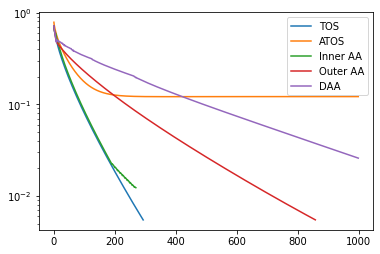

In [84]:
Sigma, port_r, port_m, port_gt, port_eval  = portfoliodata.generate_data()
n_features_port = 1000
e = np.ones(n_features_port)

p_f_copt = portfoliodata.f1_copt(Sigma)
p_f_grad = p_f_copt.f_grad
port_stepsize = 4.013 #1.99*(1/norm(Sigma))

p_G1 = portfoliodata.f2_copt()
p_G2 = portfoliodata.f3_copt(port_r,port_m)
x0_port = np.zeros(n_features_port)



port_tos_obj, port_atos_obj, port_in_aa_tos_obj, port_out_aa_tos_obj, port_daa_tos_obj = [],[],[],[],[]

#Vanilla TOS
x0_port = np.zeros(n_features_port)
port_tos_trace = Trace()
port_out = aa_tos(p_f_grad, x0_port, p_G2.prox, p_G1.prox, line_search=False, step_size = port_stepsize, callback=port_tos_trace)
trace_obj = None
trace_obj = [norm(x-port_gt)/norm(port_gt) for x in port_tos_trace.trace_x]
port_tos_obj.append(trace_obj)


#Adaptive TOS
x0_port = np.zeros(n_features_port)
port_atos_trace = Trace()
port_out = atos(p_f_grad, x0_port, p_G2.prox, p_G1.prox, step_size = port_stepsize, callback=port_atos_trace,line_search=True)
trace_obj = None
trace_obj = [norm(x-port_gt)/norm(port_gt) for x in port_atos_trace.trace_x]
port_atos_obj.append(trace_obj)


#AA (Inner only) TOS
x0_port = np.zeros(n_features_port)
port_inner_trace = Trace()
port_out = aa_tos(p_f_grad, x0_port, p_G2.prox, p_G1.prox, line_search=False, step_size = port_stepsize, callback=port_inner_trace,inner_aa=5)
trace_obj = None
trace_obj = [norm(x-port_gt)/norm(port_gt) for x in port_inner_trace.trace_x]
port_in_aa_tos_obj.append(trace_obj)


#AA Outer TOS
x0_port = np.zeros(n_features_port)
port_outer_trace = Trace()
port_out = aa_tos(p_f_grad, x0_port, p_G2.prox, p_G1.prox, line_search=False, step_size = port_stepsize, callback=port_outer_trace,outer_aa=5)
trace_obj = None
trace_obj = [norm(x-port_gt)/norm(port_gt) for x in port_outer_trace.trace_x]
port_out_aa_tos_obj.append(trace_obj)


#DAA TOS
x0_port = np.zeros(n_features_port)
port_daa_trace = Trace()
port_out = aa_tos(p_f_grad, x0_port, p_G2.prox, p_G1.prox, line_search=False, step_size = port_stepsize, callback=port_daa_trace,inner_aa=5,outer_aa=5)
trace_obj = None
trace_obj = [norm(x-port_gt)/norm(port_gt) for x in port_daa_trace.trace_x]
port_daa_tos_obj.append(trace_obj)



fig1 = plt.figure()
plt.plot(port_tos_obj[0], label='TOS')
plt.plot(port_atos_obj[0], label='ATOS')
plt.plot(port_in_aa_tos_obj[0], label='Inner AA')
plt.plot(port_out_aa_tos_obj[0], label='Outer AA')
plt.plot(port_daa_tos_obj[0], label='DAA')
plt.legend()
plt.yscale('log')



Overlapping Lasso

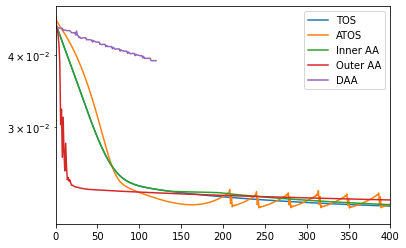

In [85]:
A_ls,b_ls,f_ls,groups_ls,GT_ls,n_features_ls,ls_stepsize = overlapping_group_lasso.generate_data()

beta = 0.001 #0.0001

ls_tos_obj, ls_atos_obj, ls_in_tos_obj, ls_out_tos_obj, ls_daa_tos_obj = [],[],[],[],[]
G1 = GroupL1(beta,groups_ls[::2])
G2 = GroupL1(beta,groups_ls[1::2])


#Vanilla TOS
ls_tos_trace = Trace()
tos_out = aa_tos(f_ls.f_grad,np.zeros(n_features_ls), G1.prox, G2.prox, step_size=10*ls_stepsize, line_search=False,callback=ls_tos_trace)
trace_obj = None
trace_obj = [overlapping_group_lasso.loss(x,f_ls,G1,G2) for x in ls_tos_trace.trace_x]
ls_tos_obj.append(trace_obj)

#ATOS
ls_atos_trace = Trace()
tos_out = atos(f_ls.f_grad,np.zeros(n_features_ls), G1.prox, G2.prox, step_size=10*ls_stepsize, line_search=True,callback=ls_atos_trace,h_Lipschitz=beta)
trace_obj = None
trace_obj = [overlapping_group_lasso.loss(x,f_ls,G1,G2) for x in ls_atos_trace.trace_x]
ls_atos_obj.append(trace_obj)

#Inner AA
ls_in_tos_trace = Trace()
tos_out = aa_tos(f_ls.f_grad,np.zeros(n_features_ls), G1.prox, G2.prox, step_size=10*ls_stepsize, line_search=False,callback=ls_in_tos_trace, inner_aa=5)
trace_obj = None
trace_obj = [overlapping_group_lasso.loss(x,f_ls,G1,G2) for x in ls_in_tos_trace.trace_x]
ls_in_tos_obj.append(trace_obj)

#Outer AA
ls_out_tos_trace = Trace()
tos_out = aa_tos(f_ls.f_grad,np.zeros(n_features_ls), G1.prox, G2.prox, step_size=10*ls_stepsize, line_search=False,callback=ls_out_tos_trace, outer_aa=5)
trace_obj = None
trace_obj = [overlapping_group_lasso.loss(x,f_ls,G1,G2) for x in ls_out_tos_trace.trace_x]
ls_out_tos_obj.append(trace_obj)

#DAA
ls_daa_tos_trace = Trace()
tos_out = aa_tos(f_ls.f_grad,np.zeros(n_features_ls), G1.prox, G2.prox, step_size=10*ls_stepsize, line_search=False,callback=ls_daa_tos_trace, inner_aa = 5, outer_aa=5)
trace_obj = None
trace_obj = [overlapping_group_lasso.loss(x,f_ls,G1,G2) for x in ls_daa_tos_trace.trace_x]
ls_daa_tos_obj.append(trace_obj)





fig1 = plt.figure()
plt.plot(ls_tos_obj[0], label='TOS')
plt.plot(ls_atos_obj[0], label='ATOS')
plt.plot(ls_in_tos_obj[0], label='Inner AA')
plt.plot(ls_out_tos_obj[0], label='Outer AA')
plt.plot(ls_daa_tos_obj[0], label='DAA')
plt.legend()
plt.xlim([0,400])
plt.yscale('log')






Anisotropic

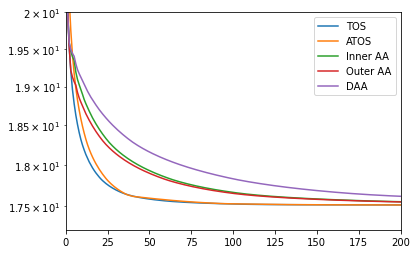

In [83]:
sample_tos_obj, sample_tos_copt_obj, sample_atos_obj, sample_in_tos_obj, sample_out_tos_obj, sample_daa_tos_obj = [],[],[],[],[],[]

n  = 100
k1 = 10
k2 = 10000
e = np.ones(2*n)
lbd = 1.e-8
f_opt = sampledata.f_copt(n,k1,k2)
g_opt = tomodata.f1_copt(e,lbd)

#Vanilla TOS
mu = np.array(1.e-6)
h_opt = tomodata.f2_copt(mu)
sample_tos_trace = Trace()
sample_out = aa_tos(f_opt.f_grad, np.zeros(2*n), h_opt.prox, g_opt.prox, step_size=2/f_opt.Lip(), barrier=mu, line_search=False, callback=sample_tos_trace)
trace_obj = None
trace_obj = [f_opt(x)+g_opt(x) for x in sample_tos_trace.trace_x]
sample_tos_obj.append(trace_obj)

#Vanilla TOS-COPT
mu = np.array(1.e-6)
h_opt = tomodata.f2_copt(mu)
sample_tos_copt_trace = Trace()
sample_out = atos(f_opt.f_grad, np.zeros(2*n), h_opt.prox, g_opt.prox, step_size=2/f_opt.Lip(), barrier=mu, line_search=False, callback=sample_tos_copt_trace)
trace_obj = None
trace_obj = [f_opt(x)+g_opt(x) for x in sample_tos_copt_trace.trace_x]
sample_tos_copt_obj.append(trace_obj)

#ATOS
mu = np.array(1.e-6)
h_opt = tomodata.f2_copt(mu)
sample_atos_trace = Trace()
sample_out = atos(f_opt.f_grad, np.zeros(2*n), h_opt.prox, g_opt.prox, step_size=2/f_opt.Lip(), barrier=mu, line_search=True, h_Lipschitz=lbd, callback=sample_atos_trace)
trace_obj = None
trace_obj = [f_opt(x)+g_opt(x) for x in sample_atos_trace.trace_x]
sample_atos_obj.append(trace_obj)

#Inner TOS
mu = np.array(1.e-6)
h_opt = tomodata.f2_copt(mu)
sample_in_tos_trace = Trace()
sample_out = aa_tos(f_opt.f_grad, np.zeros(2*n), h_opt.prox, g_opt.prox, step_size=2/f_opt.Lip(), barrier=mu, line_search=False, callback=sample_in_tos_trace, inner_aa=5)
trace_obj = None
trace_obj = [f_opt(x)+g_opt(x) for x in sample_in_tos_trace.trace_x]
sample_in_tos_obj.append(trace_obj)

#Outer TOS
mu = np.array(1.e-6)
h_opt = tomodata.f2_copt(mu)
sample_out_tos_trace = Trace()
sample_out = aa_tos(f_opt.f_grad, np.zeros(2*n), h_opt.prox, g_opt.prox, step_size=2/f_opt.Lip(), barrier=mu, line_search=False, callback=sample_out_tos_trace, outer_aa=5)
trace_obj = None
trace_obj = [f_opt(x)+g_opt(x) for x in sample_out_tos_trace.trace_x]
sample_out_tos_obj.append(trace_obj)

#DAA TOS
mu = np.array(1.e-6)
h_opt = tomodata.f2_copt(mu)
sample_daa_tos_trace = Trace()
sample_out = aa_tos(f_opt.f_grad, np.zeros(2*n), h_opt.prox, g_opt.prox, step_size=2/f_opt.Lip(), barrier=mu, line_search=False, callback=sample_daa_tos_trace, inner_aa=5, outer_aa=5)
trace_obj = None
trace_obj = [f_opt(x)+g_opt(x) for x in sample_daa_tos_trace.trace_x]
sample_daa_tos_obj.append(trace_obj)





fig1 = plt.figure()
plt.plot(sample_tos_obj[0], label='TOS')
plt.plot(sample_atos_obj[0], label='ATOS')
plt.plot(sample_in_tos_obj[0], label='Inner AA')
plt.plot(sample_out_tos_obj[0], label='Outer AA')
plt.plot(sample_daa_tos_obj[0], label='DAA')
plt.legend()
plt.ylim(top=20)
plt.xlim([0,200])
plt.yscale('log')





Sparse Nuclear Norm

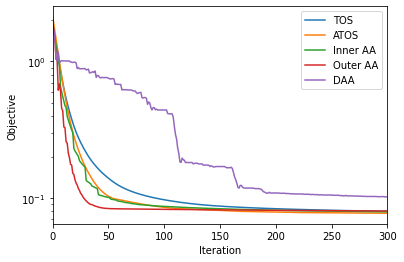

In [94]:
beta = 1.e-3 #1.e-2,1.e-3,0

Sigma, f, step_size, n_features = sparse_nuclear_norm.generate_data()

G1 = sparse_nuclear_norm.TraceNorm(beta,Sigma.shape)
G2 = sparse_nuclear_norm.L1Norm(beta)

nuc_tos, nuc_atos, nuc_inner_tos, nuc_outer_tos, nuc_daa_tos = [],[],[],[],[]
def loss(x):
    return f(x) + G1(x) + G2(x)

#TOS
tos_trace = Trace()
nuc_out = aa_tos(f.f_grad,np.zeros(n_features),G1.prox,G2.prox, step_size=step_size, line_search=False, callback=tos_trace)
trace_obj = np.array([loss(x) for x in tos_trace.trace_x])
nuc_tos.append(trace_obj)

#ATOS
atos_trace = Trace()
nuc_out = atos(f.f_grad,np.zeros(n_features),G1.prox,G2.prox, step_size=step_size, line_search=True, h_Lipschitz=beta,callback=atos_trace)
trace_obj = np.array([loss(x) for x in atos_trace.trace_x])
nuc_atos.append(trace_obj)

#Inner AA TOS
inner_trace = Trace()
nuc_out = aa_tos(f.f_grad,np.zeros(n_features),G1.prox,G2.prox, step_size=step_size, line_search=False, callback=inner_trace,inner_aa=5)
trace_obj = np.array([loss(x) for x in inner_trace.trace_x])
nuc_inner_tos.append(trace_obj)

#Outer AA TOS
outer_trace = Trace()
nuc_out = aa_tos(f.f_grad,np.zeros(n_features),G1.prox,G2.prox, step_size=step_size, line_search=False, callback=outer_trace,outer_aa=5)
trace_obj = np.array([loss(x) for x in outer_trace.trace_x])
nuc_outer_tos.append(trace_obj)

#DAA TOS
daa_trace = Trace()
nuc_out = aa_tos(f.f_grad,np.zeros(n_features),G1.prox,G2.prox, step_size=step_size, line_search=False, callback=daa_trace,inner_aa=5,outer_aa=5)
trace_obj = np.array([loss(x) for x in daa_trace.trace_x])
nuc_daa_tos.append(trace_obj)


fig1 = plt.figure()
plt.plot(nuc_tos[0], label='TOS')
plt.plot(nuc_atos[0], label='ATOS')
plt.plot(nuc_inner_tos[0], label='Inner AA')
plt.plot(nuc_outer_tos[0], label='Outer AA')
plt.plot(nuc_daa_tos[0], label='DAA')
plt.legend()
#plt.ylim(top=1)
plt.xlim([0,300])
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.yscale('log')

